In [ ]:
!"{sys.executable}" -m pip install --upgrade pip
!"{sys.executable}" -m pip install numpy
!"{sys.executable}" -m pip install tensorflow
!"{sys.executable}" -m pip install StandardScaler
!"{sys.executable}" -m pip install scikit-learn
!"{sys.executable}" -m pip install joblib

In [96]:
import sys
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import numpy as np
import os
import random


In [97]:
import numpy as np
import random

# 기존 전역 변수들
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed) # TensorFlow 시드도 설정 (셀 3에서 이미 했지만, 여기서도 명시)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

MIN_LEN = 1 # 0으로 하면 a+b=c 같은 경우 0,0,0 이 나올 수 있어 1로 유지
MAX_LEN = 100
INPUT_SHAPE_MODEL = (3,)

# --- 일반 랜덤 케이스 생성 함수 ---
def gen_random_triangle_sides(num_target_samples_each_type):
    """일반적인 성공/실패 케이스를 각각 num_target_samples_each_type 만큼 랜덤 생성"""
    success_cases = []
    fail_cases = []
    while len(success_cases) < num_target_samples_each_type or len(fail_cases) < num_target_samples_each_type:
        sides = np.random.randint(MIN_LEN, MAX_LEN + 1, 3)
        # 생성된 sides가 이미 해당 타입의 목표량을 채웠으면 다른 타입만 시도
        if is_valid_triangle(sides):
            if len(success_cases) < num_target_samples_each_type:
                success_cases.append(sides)
        else:
            if len(fail_cases) < num_target_samples_each_type:
                fail_cases.append(sides)
    return np.array(success_cases), np.array(fail_cases)

# --- 엣지 케이스 생성 함수들 ---
def gen_edge_degenerate_fail_cases(num_target_samples):
    """엣지 실패 케이스 1: a + b = c (c가 가장 긴 변)"""
    fail_cases = []
    while len(fail_cases) < num_target_samples:
        # 두 변 a, b를 랜덤 생성
        a = np.random.randint(MIN_LEN, MAX_LEN // 2 + 1) # a+b=c 이므로 a, b가 너무 크면 c가 MAX_LEN 초과
        b = np.random.randint(MIN_LEN, MAX_LEN // 2 + 1)
        c = a + b
        if MIN_LEN <= c <= MAX_LEN: # c도 범위 내에 있어야 함
            sides = sorted([a, b, c]) # 함수 내부에서 사용하기 위해 정렬된 값
            if not is_valid_triangle(sides): # 실제 삼각형이 아님을 재확인 (a+b=c는 삼각형이 아님)
                 fail_cases.append(np.array(sides)) # 저장 시에는 정렬 안해도 무방하나, 일관성 위해 정렬
    return np.array(fail_cases)

def gen_edge_narrow_fail_cases(num_target_samples):
    """엣지 실패 케이스 2: 0 < a + b - c < MAX_LEN / 20 (아슬아슬하게 안되는 경우)"""
    fail_cases = []
    delta_upper_bound = MAX_LEN / 20
    while len(fail_cases) < num_target_samples:
        # c (가장 긴 변)를 먼저 설정하는 것이 조건 맞추기 용이
        c = np.random.randint(MIN_LEN + int(delta_upper_bound) + 1, MAX_LEN + 1) # a+b가 c보다 약간 작아야 하므로 c는 너무 작으면 안됨
        # a + b = c + delta (여기서 delta는 - (MAX_LEN/20) < delta < 0)
        # delta 값 (매우 작은 음수 값)
        # 실제로는 a+b-c = (작은 양수) 이므로, a+b = c + (작은 양수)
        # is_valid_triangle에서는 a+b > c 로 판별하므로, a+b-c가 음수 또는 0이어야 함
        # 수정: a+b-c가 (0, MAX_LEN/20) 사이의 음수값이 되도록. 즉 c - (a+b) 가 (0, MAX_LEN/20)
        diff = random.uniform(0.001, delta_upper_bound - 0.001) # c가 a+b보다 이만큼 더 크도록
        
        # a, b를 생성. a+b = c - diff
        # 한 변 a를 먼저 생성
        # MIN_LEN <= a <= c - MIN_LEN - diff (b가 MIN_LEN 이상이 되도록)
        # MAX_LEN을 넘지 않도록 주의
        if c - diff - MIN_LEN < MIN_LEN : continue # a를 만들 범위가 없으면 스킵

        a = np.random.randint(MIN_LEN, int(min(MAX_LEN, c - diff - MIN_LEN)) + 1)
        b = c - diff - a

        if MIN_LEN <= b <= MAX_LEN and b > 0 and a <= b <=c : # b의 유효성 및 정렬된 상태 가정
            sides = sorted([a, int(round(b)), c]) # b가 float일 수 있으므로 반올림
            if not is_valid_triangle(sides) and (sides[0]+sides[1] < sides[2]) and (sides[2]-(sides[0]+sides[1]) < delta_upper_bound) and (sides[2]-(sides[0]+sides[1]) > 0) :
                 fail_cases.append(np.array(sides))
            # 실패하면 다른 값으로 재시도 (루프 계속)
    return np.array(fail_cases)


def gen_edge_narrow_success_cases(num_target_samples):
    """엣지 성공 케이스: MAX_LEN / 20 <= a + b - c (c가 가장 긴 변)
       그리고 너무 차이가 크지 않도록 a + b - c <= MAX_LEN / 10 정도로 제한 가능
    """
    success_cases = []
    delta_lower_bound = MAX_LEN / 20
    delta_upper_bound = MAX_LEN / 10 # 너무 쉽게 성공하는 경우를 약간 제한
    while len(success_cases) < num_target_samples:
        c = np.random.randint(MIN_LEN, MAX_LEN + 1)
        # a + b = c + delta (여기서 delta는 delta_lower_bound와 delta_upper_bound 사이)
        diff = random.uniform(delta_lower_bound, delta_upper_bound)
        
        # a, b를 생성. a+b = c + diff
        # 한 변 a를 먼저 생성. 
        # MIN_LEN <= a <= c + diff - MIN_LEN (b가 MIN_LEN 이상)
        # MAX_LEN을 넘지 않도록 주의
        # c+diff-MIN_LEN 이 MIN_LEN 보다 작으면 a 생성 불가
        if c + diff - MIN_LEN < MIN_LEN : continue

        # a의 상한은 MAX_LEN과 (c+diff-MIN_LEN) 중 작은 값
        a_upper_limit = int(min(MAX_LEN, c + diff - MIN_LEN))
        if MIN_LEN > a_upper_limit: continue # a를 만들 범위가 없으면 스킵
            
        a = np.random.randint(MIN_LEN, a_upper_limit + 1)
        b = c + diff - a

        if MIN_LEN <= b <= MAX_LEN and b > 0:
            sides = sorted([a, int(round(b)), c]) # b가 float일 수 있으므로 반올림
            if is_valid_triangle(sides) and (sides[0]+sides[1]-sides[2] >= delta_lower_bound) and (sides[0]+sides[1]-sides[2] <= delta_upper_bound) :
                 success_cases.append(np.array(sides))
            # 실패하면 다른 값으로 재시도
    return np.array(success_cases)

# --- 삼각형 유효성 검사 함수 ---
def is_valid_triangle(three_sides):
    """세 변이 삼각형을 이룰 수 있는지 체크"""
    a, b, c = sorted(np.round(three_sides).astype(int)) # 정수형으로 변환 후 정렬
    # 모든 변이 MIN_LEN 이상인지 먼저 체크 (0이나 음수 방지)
    if not (a >= MIN_LEN and b >= MIN_LEN and c >= MIN_LEN):
        return False
    return (a + b) > c

In [98]:
# --- 전체 샘플 수 및 각 타입별 샘플 수 정의 ---
num_total_samples = 100000 # 예시로 10만개, 필요시 조정

# 일반 케이스 (70%)
num_general_samples_total = int(num_total_samples * 0.70)
num_general_samples_each_type = num_general_samples_total // 2 # 성공/실패 각각

# 엣지 케이스 (총 30%)
num_edge_degenerate_fail = int(num_total_samples * 0.05)    # a+b=c
num_edge_narrow_fail = int(num_total_samples * 0.10)        # 아슬아슬 실패
num_edge_narrow_success = int(num_total_samples * 0.15)     # 아슬아슬 성공

# --- 데이터 생성 실행 ---
print("일반 케이스 생성 중...")
general_success_cases, general_fail_cases = gen_random_triangle_sides(num_general_samples_each_type)
print(f"일반 성공: {len(general_success_cases)}, 일반 실패: {len(general_fail_cases)}")

print("엣지 케이스 (a+b=c, 실패) 생성 중...")
edge_fail_degenerate = gen_edge_degenerate_fail_cases(num_edge_degenerate_fail)
print(f"엣지 (a+b=c) 실패: {len(edge_fail_degenerate)}")

print("엣지 케이스 (아슬아슬 실패) 생성 중...")
edge_fail_narrow = gen_edge_narrow_fail_cases(num_edge_narrow_fail)
print(f"엣지 (아슬아슬) 실패: {len(edge_fail_narrow)}")

print("엣지 케이스 (아슬아슬 성공) 생성 중...")
edge_success_narrow = gen_edge_narrow_success_cases(num_edge_narrow_success)
print(f"엣지 (아슬아슬) 성공: {len(edge_success_narrow)}")

# --- 모든 성공 케이스와 실패 케이스 결합 ---
all_success_cases = np.concatenate([general_success_cases, edge_success_narrow])
all_fail_cases = np.concatenate([general_fail_cases, edge_fail_degenerate, edge_fail_narrow])

print(f"총 성공 케이스: {len(all_success_cases)}")
print(f"총 실패 케이스: {len(all_fail_cases)}")

In [ ]:
# 데이터 결합 및 라벨 생성
all_cases = np.concatenate([all_success_cases, all_fail_cases]) # 수정된 코드
labels = np.concatenate([np.ones(len(all_success_cases)), np.zeros(len(all_fail_cases))])

# 데이터 정규화 (StandardScaler 사용)
scaler = StandardScaler()
# all_cases는 이미 (N, 3) 형태이므로 reshape 불필요
norm_all_cases = scaler.fit_transform(all_cases) 
joblib.dump(scaler, 'scaler.pkl')

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    norm_all_cases, labels, test_size=0.2, random_state=seed, stratify=labels
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1600000, 3), y_train shape: (1600000,)
X_test shape: (400000, 3), y_test shape: (400000,)


In [100]:
# 데이터 결합 및 라벨 생성
all_cases = np.concatenate([success_cases, fail_cases])
labels = np.concatenate([np.ones(len(success_cases)), np.zeros(len(fail_cases))])

# 셀 6에서 StandardScaler 대신
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
norm_all_cases = scaler.fit_transform(all_cases)
joblib.dump(scaler, 'scaler.pkl') # scaler 저장

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    norm_all_cases, labels, test_size=0.2, random_state=seed, stratify=labels
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1600000, 3), y_train shape: (1600000,)
X_test shape: (400000, 3), y_test shape: (400000,)


In [101]:
# AI 모델 생성 (Create AI model)
model = models.Sequential([
    layers.Input(shape=INPUT_SHAPE_MODEL),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2), # 과적합 방지 (현재는 과적합이 아니지만, 모델 복잡도 증가 시 고려)
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일 (Compile model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,881 (42.50 KB)

 Trainable params: 10,881 (42.50 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
# 모델 학습 (Train Model) - 학습 데이터 사용
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가 (Evaluate Model) - 테스트 데이터 사용
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 0.9764 - loss: 0.0546 - val_accuracy: 0.9898 - val_loss: 0.0184
Epoch 2/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 0.9895 - loss: 0.0255 - val_accuracy: 0.9896 - val_loss: 0.0287
Epoch 3/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - accuracy: 0.9914 - loss: 0.0210 - val_accuracy: 0.9922 - val_loss: 0.0196
Epoch 4/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 0.9924 - loss: 0.0189 - val_accuracy: 0.9985 - val_loss: 0.0080
Epoch 5/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - accuracy: 0.9935 - loss: 0.0165 - val_accuracy: 0.9955 - val_loss: 0.0099
Epoch 6/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 0.9939 - loss: 0.0155 - val_accuracy: 0.9981 - val_loss: 0.0089
Epoch 7/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 0.9945 - loss: 0.0140 - val_accuracy: 0.9981 - val_loss: 0.0075
Epoch 8/25
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - accuracy: 

In [103]:
# 모델 저장 (Save the model)
model.save("model.h5")
print("Model saved as model.h5")

Model saved as model.h5


In [104]:
# 저장된 모델과 scaler를 사용한 예측 예시
loaded_model = models.load_model("model.h5")
loaded_scaler = joblib.load("scaler.pkl")

# 예시 데이터 (정규화 필요)
example_valid = np.array([[3, 4, 5]]) # 유효
example_invalid = np.array([[1, 2, 10]]) # 유효하지 않음

norm_example_valid = loaded_scaler.transform(example_valid)
norm_example_invalid = loaded_scaler.transform(example_invalid)

prediction_valid = loaded_model.predict(norm_example_valid)
prediction_invalid = loaded_model.predict(norm_example_invalid)

print(f"Prediction for {example_valid[0]}: {prediction_valid[0][0]:.4f} (Expected > 0.5)")
print(f"Prediction for {example_invalid[0]}: {prediction_invalid[0][0]:.4f} (Expected < 0.5)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for [3 4 5]: 0.9999 (Expected > 0.5)
Prediction for [ 1  2 10]: 0.0000 (Expected < 0.5)


In [105]:
import tensorflow as tf

# GPU 사용 여부 확인
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 현재 프로그램에 필요한 만큼만 GPU 메모리 할당
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # 프로그램 시작 후에는 메모리 증가 설정을 변경할 수 없으므로 오류 발생 가능
        print(e)
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


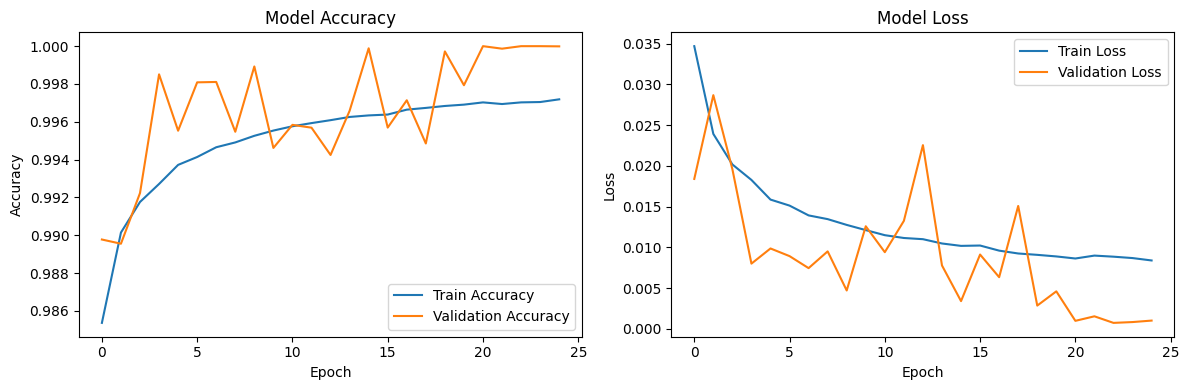

In [106]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
# 저장된 모델과 scaler를 사용한 예측 예시
loaded_model = models.load_model("model.h5")
loaded_scaler = joblib.load("scaler.pkl")

# 테스트할 예시 데이터들
examples = {
    "Valid (3,4,5)": np.array([[3, 4, 5]]),
    "Valid (5,12,13)": np.array([[5, 12, 13]]),
    "Valid (7,7,7) (Equilateral)": np.array([[7, 7, 7]]),
    "Valid (5,5,8) (Isosceles)": np.array([[5, 5, 8]]),
    "Invalid (1,2,10)": np.array([[1, 2, 10]]),
    "Invalid (5,5,10) (Degenerate)": np.array([[5, 5, 10]]), # a+b = c
    "Invalid (1,100,100.5) (Near valid)": np.array([[1, 100, 100.5]]),
    "Invalid (0,0,0)": np.array([[0,0,0]]), # Should be invalid, though MIN_LEN is 1
    "Valid (large_1)": np.array([[500, 600, 700]]),
    "Invalid (large_2)": np.array([[10, 20, 1000]]),
}

print("Model Predictions (0 = Invalid, 1 = Valid):")
for name, data in examples.items():
    # 데이터 정규화
    norm_data = loaded_scaler.transform(data)
    # 예측
    prediction = loaded_model.predict(norm_data)
    # 결과 출력
    is_actually_valid = is_valid_triangle(data[0]) # 실제 유효성 검사
    print(f"- {name}: Predicted {prediction[0][0]:.4f} (Actual: {'Valid' if is_actually_valid else 'Invalid'})")


Model Predictions (0 = Invalid, 1 = Valid):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
- Valid (3,4,5): Predicted 0.9999 (Actual: Valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
- Valid (5,12,13): Predicted 0.9999 (Actual: Valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
- Valid (7,7,7) (Equilateral): Predicted 0.9999 (Actual: Valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
- Valid (5,5,8) (Isosceles): Predicted 0.9999 (Actual: Valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
- Invalid (1,2,10): Predicted 0.0000 (Actual: Invalid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
- Invalid (5,5,10) (Degenerate): Predicted 0.0436 (Actual: Invalid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
- Invalid (1,100,100.5) (Near valid): Predicted 0.7119 (Actual: Valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
- Invalid (0,0,0): Predicted 0.0001 (Actual: Invalid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
- Valid (large_1): Predicted 1.0000 (Actual: Valid)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
- Invalid (large_2): Predicted 0.0000 (Actual: I